# EWX Forecasting Walkthrough

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import json
import math
from collections import deque
import EWX_forecast as ewx
import pprint
import os

csv = "/home/jupyter-engiela/la-tools-test/EWX_Forecast/csv"

## Chose file to upload

In [2]:
files = ewx.sortdir(csv, 10)

files found in dir:  /home/jupyter-engiela/la-tools-test/EWX_Forecast/csv
                                  files                time
0  NEPOOL_MECO_4070532011_timeshift.csv 2019-09-01 07:45:26
1        NEPOOL_MECO_4070532011_val.csv 2019-09-01 07:45:19
2            NEPOOL_MECO_4070532011.csv 2019-09-01 07:41:02
3                    .ipynb_checkpoints 2019-09-01 07:35:55
4                              init.git 2019-08-31 01:04:26


In [3]:
myfile = files.files[2]
print('working with {}'.format(myfile))

working with NEPOOL_MECO_4070532011.csv


## Import & plot

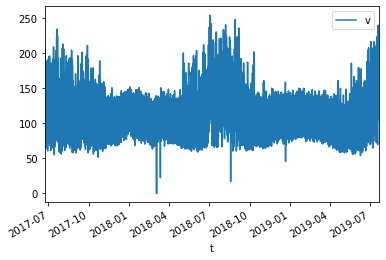

In [7]:
idr = pd.read_csv(myfile)
idr.columns = ['t', 'v']
idr['v'] = pd.to_numeric(idr['v'], errors = 'coerce')
idr.t = pd.to_datetime(idr.t)
idr.set_index(pd.DatetimeIndex(idr.t), inplace = True, drop = True)
idr = idr.drop('t', axis = 1)
idr.plot(y = 'v')

# Default IDR Config

## Periodic Zeros
1. threshold (less than this is considered zero) 
2. periodicity percent (percent of time weekdays have to be zero to be nonperiodic)

In [5]:
#check for nonperiodic zeros
tmp2 = ewx.periodic_zero(idr, .01, 1)
tmp2.head()

,v,d,h,pz,lr
t,,,,,
2017-06-22 00:00:00,86.928,3,0,0.0,False
2017-06-22 01:00:00,83.808,3,1,0.0,False
2017-06-22 02:00:00,72.432,3,2,0.0,False
2017-06-22 03:00:00,70.656,3,3,0.0,False
2017-06-22 04:00:00,71.568,3,4,0.0,False


## Interval Gap Check
1. checks time differences (expects to be one hour)

In [9]:
tmp2['mon'] = [a.month for a in tmp2.index]
 
#get value & time differences
tmp2 = ewx.interval_gap_check(tmp2)
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap
t,,,,,,,,,
2017-06-22 00:00:00,86.928,3,0,0.0,False,6,0.000,1.0,False
2017-06-22 01:00:00,83.808,3,1,0.0,False,6,-3.120,1.0,False
2017-06-22 02:00:00,72.432,3,2,0.0,False,6,-11.376,1.0,False
2017-06-22 03:00:00,70.656,3,3,0.0,False,6,-1.776,1.0,False
2017-06-22 04:00:00,71.568,3,4,0.0,False,6,0.912,1.0,False


## Variance Validation
1. time window to calculate rolling statistics
2. should window be centered
3. number of standard deviations used to flag spikes & dips

In [10]:
#check spikes & dips
#time_window = int(60*24*3600/hb)
time_window = int(30*24)
centered = True
n_sd = 4

tmp2 = ewx.variance_validation(tmp2, time_window, centered, 2)
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap,rm,mc,crm,crsd,var,spike,dip
t,,,,,,,,,,,,,,,,
2017-06-22 00:00:00,86.928,3,0,0.0,False,6,0.000,1.0,False,129.352267,-42.424267,1.149779,39.262269,-37.897772,False,False
2017-06-22 01:00:00,83.808,3,1,0.0,False,6,-3.120,1.0,False,129.215734,-45.407734,1.004888,39.304228,-46.186880,False,False
2017-06-22 02:00:00,72.432,3,2,0.0,False,6,-11.376,1.0,False,129.076110,-56.644110,0.856903,39.350612,-67.103309,False,False
2017-06-22 03:00:00,70.656,3,3,0.0,False,6,-1.776,1.0,False,128.927471,-58.271471,0.699882,39.409937,-84.259000,False,False
2017-06-22 04:00:00,71.568,3,4,0.0,False,6,0.912,1.0,False,128.779912,-57.211912,0.543897,39.467976,-106.188957,False,False


## DST Check, Fix Nonhourly Intervals, Flag NA
1. missing hour in March window or extra in Nov window - cleans
2. adjusts nonhourly data
3. flags values that were initially missing

In [11]:
#check for dst (missing hour 3/8-3/14 and extra value 11/1-11/7)
tmp2 = ewx.dst_check(tmp2)
tmp2 = ewx.fix_interval(tmp2)
tmp2['na'] = [v == .123456789 for v in tmp2['v']]
tmp2.head()

Index(['v_orig', 'd', 'h', 'pz', 'lr', 'mon', 'vd', 'td', 'gap', 'rm', 'mc',
       'crm', 'crsd', 'var', 'spike', 'dip', 'dst', 'date', 'y', 'min', 'v'],
      dtype='object')


,v_orig,d,h,pz,lr,mon,vd,td,gap,rm,...,crsd,var,spike,dip,dst,date,y,min,v,na
t,,,,,,,,,,,,,,,,,,,,,
2017-06-22 00:00:00,86.928,22,0,0.0,False,6,0.000,1.0,False,129.352267,...,39.262269,-37.897772,False,False,False,"(2017, 6, 22, 0, 0)",2017,0,86.928,False
2017-06-22 01:00:00,83.808,22,1,0.0,False,6,-3.120,1.0,False,129.215734,...,39.304228,-46.186880,False,False,False,"(2017, 6, 22, 1, 0)",2017,0,83.808,False
2017-06-22 02:00:00,72.432,22,2,0.0,False,6,-11.376,1.0,False,129.076110,...,39.350612,-67.103309,False,False,False,"(2017, 6, 22, 2, 0)",2017,0,72.432,False
2017-06-22 03:00:00,70.656,22,3,0.0,False,6,-1.776,1.0,False,128.927471,...,39.409937,-84.259000,False,False,False,"(2017, 6, 22, 3, 0)",2017,0,70.656,False
2017-06-22 04:00:00,71.568,22,4,0.0,False,6,0.912,1.0,False,128.779912,...,39.467976,-106.188957,False,False,False,"(2017, 6, 22, 4, 0)",2017,0,71.568,False


# Flag Errors

In [12]:
data_filter = [a or b or c or d or e for a, b, c, d, e in zip(tmp2.lr, tmp2.gap, tmp2.spike, tmp2.dip, tmp2.na)]
tmp2['err'] = data_filter
tmp2.head()

,v_orig,d,h,pz,lr,mon,vd,td,gap,rm,...,var,spike,dip,dst,date,y,min,v,na,err
t,,,,,,,,,,,,,,,,,,,,,
2017-06-22 00:00:00,86.928,22,0,0.0,False,6,0.000,1.0,False,129.352267,...,-37.897772,False,False,False,"(2017, 6, 22, 0, 0)",2017,0,86.928,False,False
2017-06-22 01:00:00,83.808,22,1,0.0,False,6,-3.120,1.0,False,129.215734,...,-46.186880,False,False,False,"(2017, 6, 22, 1, 0)",2017,0,83.808,False,False
2017-06-22 02:00:00,72.432,22,2,0.0,False,6,-11.376,1.0,False,129.076110,...,-67.103309,False,False,False,"(2017, 6, 22, 2, 0)",2017,0,72.432,False,False
2017-06-22 03:00:00,70.656,22,3,0.0,False,6,-1.776,1.0,False,128.927471,...,-84.259000,False,False,False,"(2017, 6, 22, 3, 0)",2017,0,70.656,False,False
2017-06-22 04:00:00,71.568,22,4,0.0,False,6,0.912,1.0,False,128.779912,...,-106.188957,False,False,False,"(2017, 6, 22, 4, 0)",2017,0,71.568,False,False


# Interpolate Error Values

In [13]:
tmp2['interp'] = ewx.interp(tmp2.v, tmp2.err)
    
linear = tmp2.interp.interpolate(method = 'linear', axis = 0, in_place = False, limit_direction = 'forward')
tmp2['lin'] = linear
tmp2.lin[tmp2.lin.isnull()] = tmp2.v[tmp2.lin.isnull()]
tmp2.head()

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,v_orig,d,h,pz,lr,mon,vd,td,gap,rm,...,dip,dst,date,y,min,v,na,err,interp,lin
t,,,,,,,,,,,,,,,,,,,,,
2017-06-22 00:00:00,86.928,22,0,0.0,False,6,0.000,1.0,False,129.352267,...,False,False,"(2017, 6, 22, 0, 0)",2017,0,86.928,False,False,86.928,86.928
2017-06-22 01:00:00,83.808,22,1,0.0,False,6,-3.120,1.0,False,129.215734,...,False,False,"(2017, 6, 22, 1, 0)",2017,0,83.808,False,False,83.808,83.808
2017-06-22 02:00:00,72.432,22,2,0.0,False,6,-11.376,1.0,False,129.076110,...,False,False,"(2017, 6, 22, 2, 0)",2017,0,72.432,False,False,72.432,72.432
2017-06-22 03:00:00,70.656,22,3,0.0,False,6,-1.776,1.0,False,128.927471,...,False,False,"(2017, 6, 22, 3, 0)",2017,0,70.656,False,False,70.656,70.656
2017-06-22 04:00:00,71.568,22,4,0.0,False,6,0.912,1.0,False,128.779912,...,False,False,"(2017, 6, 22, 4, 0)",2017,0,71.568,False,False,71.568,71.568


# Write Validated Data

In [14]:
#final validated data

print('writing validated data to .csv...')
final = tmp2.copy()
val = myfile.split('.')[0]
val_file = ''.join([val, '_val.csv'])
final.to_csv(val_file, header = True, index = True)
print('wrote {} to {}.'.format(val_file, os.getcwd()))

writing validated data to .csv...
wrote NEPOOL_MECO_4070532011_val.csv to /home/jupyter-engiela/la-tools-test/EWX_Forecast/csv.


# Timeshift/Forecast
1. shift validated data *years* in the future

In [15]:
forecast = ewx.timeshift(final, 10)
    
print('writing forecasts to .csv...')
name = myfile.split('.')[0]
ts_name = '_'.join([name, 'timeshift'])
ts_name = '.'.join([ts_name, 'csv'])
forecast.to_csv(ts_name, header = False)
print('wrote {} to {}.'.format(ts_name, os.getcwd()))
forecast.head()

/home/jupyter-engiela/la-tools-test/EWX_Forecast/EWX_forecast.py:465: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  master = pd.concat([year_data, future], axis = 0)
/home/jupyter-engiela/la-tools-test/EWX_Forecast/EWX_forecast.py:477: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  master = pd.concat([master, forecast], axis = 0)


forecasted year 0 of 10 with 8736 reads.
forecasted year 1 of 10 with 8736 reads.
forecasted year 2 of 10 with 8736 reads.
forecasted year 3 of 10 with 8736 reads.
forecasted year 4 of 10 with 8736 reads.
forecasted year 5 of 10 with 8736 reads.
forecasted year 6 of 10 with 8736 reads.
forecasted year 7 of 10 with 8736 reads.
forecasted year 8 of 10 with 8736 reads.
forecasted year 9 of 10 with 8736 reads.
forecasted year 10 of 10 with 8736 reads.
writing forecasts to .csv...
wrote NEPOOL_MECO_4070532011_timeshift.csv to /home/jupyter-engiela/la-tools-test/EWX_Forecast/csv.


,v
t,
2018-07-23 00:00:00,103.392
2018-07-23 01:00:00,101.712
2018-07-23 02:00:00,99.936
2018-07-23 03:00:00,102.432
2018-07-23 04:00:00,120.192


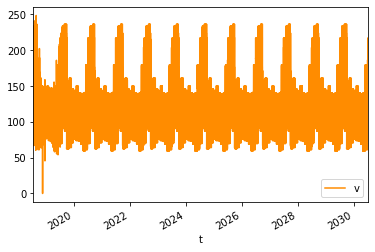

In [16]:
forecast.plot(y = 'v', color = 'darkorange')